# SSD300 Training Tutorial

This tutorial explains how to train an SSD300 on the Pascal VOC datasets. Training SSD512 works simiarly, so there's no extra tutorial for that. The same goes for training on other datasets.

In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

%matplotlib inline

Using TensorFlow backend.


## 0. Preliminary note

All places in the code where you need to make any changes are marked `TODO` and explained accordingly. All code cells that don't contain `TODO` markers just need to be executed.

## 1. Set the model configuration parameters

This section sets the configuration parameters for the model. The parameters set here are being used both by the `ssd_300()` function that builds the SSD300 model as well as further down by the constructor for the `SSDBoxEncoder` object that is needed to run the training.

The parameters as set below produce the original SSD300 architecture that was trained on the Pascal VOC datsets, i.e. they are all chosen to correspond exactly to their respective counterparts in the `.prototxt` file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the authors trained their models. The scaling factors used for the MS COCO dataset are smaller than the scaling factors used for the Pascal VOC datasets, so keep that in mind if you want to reproduce the results from the paper. The scaling factors defined below are for the Pascal VOC datasets. The scaling factors are given as absolute pixel values in the Caffe `.prototxt` file, but the relative scaling factors defined below produce exactly those absolute values at an image size of 300x300. The reason why the list of scaling factors has 7 elements while there are only 6 predictor layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. See the documentation for details.

The original SSD does not clip the anchor box coordinates to lie within the image boundaries, so `limit_boxes` is set to `False`. Doing this may seem counterintuitive at first, but it does make sense and it seems to lead to better model performance according to Wei Liu.

As mentioned above, the parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor further down, which is responsible for matching and encoding ground truth boxes and anchor boxes during the training. In order to do that, it needs to know the anchor box specifications.

In [2]:
img_height = 400 # Height of the input images
img_width = 600 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = True # The color channel order in the original SSD is BGR
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_voc = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids', 'corners', or 'minmax' format, see documentation
normalize_coords = True

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model and load trained VGG-16 weights into it (or trained SSD weights)

If you want to create a new SSD300 model, this is the relevant section for you. If you want to load a previously saved SSD300 model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `ssd_300()` to build the model.
2. It then loads trained VGG-16 weights into the model. You need to set the path to the VGG-16 weights file on your local machine. Of course you can also load weights from one of the original trained models instead (all download links are provided in the [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this repository).
3. Finally, it compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

I'm using an Adam optimizer with the same 0.001 initial learning rate that is stated in the paper, although of course learning rates are not entirely comparable between Adam and plain SGD with momentum. The learning rate and decay set here yield good performance nonetheless.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                l2_regularization=0.0005,
                scales=scales_voc,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                limit_boxes=limit_boxes,
                variances=variances,
                coords=coords,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels)

# 2: Load the trained VGG-16 weights into the model.

# TODO: Set the path to the VGG-16 weights.
weights_path = 'ssd300_weights_epoch-10_loss-0.0051_val_loss-0.0046.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### 2.2 Load a previously created model

If you have previously created and saved a model and would now like to load it, simply execute the next code cell. The only thing you need to do is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

In [4]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'ssd300.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training

The code cells below set up batch generators for the training and validation datasets to train the model. If you want to train the model on the Pascal VOC datasets, you need to change nothing except the filepaths to the datasets for both the training and validation generators. Note that parsing the labels from the XML files can take a while.

The original implementation uses a batch size of 32 for training, but you might have to decrease that number based on your GPU memory.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and then encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you might want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

In order to train the model on your own data, choose or write a parser method that is suitable for the format of your labels and set the paths to the image files and labels as needed. Read the documentation so you know what label format the generator expects. Also, make sure that your images are in whatever size you need them or use the resizing feature of the generator. The data augmentation features available in the generator are not identical to the techniques described in the paper, but they work well nonetheless. If there is anything you don't understand, check out the documentation.

In [5]:
# 1: Instantiate to `BatchGenerator` objects: One for training, one for validation.

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

In [6]:
# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir      = '../Dataset/Training/'
VOC_2007_test_images_dir = '../Dataset/Validation/'
# VOC_2012_images_dir      = '../../datasets/VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = '../Dataset/Training/'
VOC_2007_test_annotations_dir = '../Dataset/Validation/'
# VOC_2012_annotations_dir      = '../../datasets/VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = '../Dataset/train.txt'
# VOC_2012_train_image_set_filename    = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = '../Dataset/val.txt'
# VOC_2012_val_image_set_filename      = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = '../Dataset/val.txt'
# VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '../Dataset/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['Plastic Bottle']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                        image_set_filenames=[VOC_2007_train_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
                      image_set_filenames=[VOC_2007_val_image_set_filename],
                      annotations_dirs=[VOC_2007_test_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

Disclaimer: The data augmentation options set below in the training generator do not follow the original procedure described in the paper. In case you want to reproduce the training of the original models from scratch exactly, you'll have to modify the data generator (or build your own) to perform the same data augmentation as described in the paper of course.

Also, the data augmentation options set here are not meant to be the ideal configuration, but rather the bare minimum of data augmentation you should use. Do not take the configuration here as given - you will have to experiment with data augmentation yourself. In order to train successfully and prevent overfitting, you will likely have to use data augmentation a lot more aggressively than the settings below. Try out the random scaling and translation options for example.

In [7]:
#  3: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales_voc,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                steps=steps,
                                offsets=offsets,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.6,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 4: Set the batch size.

batch_size = 4 # Change the batch size if you like, or if you run into memory issues with your GPU.

# 5: Set the image processing / data augmentation options and create generator handles.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         convert_to_3_channels=True,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5),
                                         flip=0.5,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=(img_height, img_width, 1, 3), # This one is important because the Pascal VOC images vary in size
                                         random_pad_and_resize=(img_height, img_width, 1, 3, 0.5), # This one is important because the Pascal VOC images vary in size
                                         random_crop=True,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True, # While the anchor boxes are not being clipped, the ground truth boxes should be
                                         include_thresh=0.4)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     convert_to_3_channels=True,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=(img_height, img_width, 1, 3), # This one is important because the Pascal VOC images vary in size
                                     random_pad_and_resize=(img_height, img_width, 1, 3, 0.5), # This one is important because the Pascal VOC images vary in size
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4)

# Get the number of samples in the training and validations datasets to compute the epoch lengths below.
n_train_samples = train_dataset.get_n_samples()
n_val_samples   = val_dataset.get_n_samples()

## 4. Run the training

Now that everything is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to wherever you'd like to save the model. If you get "out of memory" errors during training, reduce the batch size.

Note that the number of epochs is arbitrarily set to 10 here. This does not imply that training for 10 epochs will be enough. It definitely won't be if you're training from scratch. What matters is the number of training steps the model is being trained for, and at which learning rate. You will usually need to train your model for tens of thousands of training steps. Just for reference, the original SSD300 models were trained for 120,000 to 440,000 training steps, depending on the datasets. You should, however start to see half-decent results after around 20,000 training steps, somewhere in this ballpark. The number of training steps that one epoch consists of depends on the size of your training dataset and on the chosen batch size.

In [8]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch <= 100: return 0.0001
    else: return 0.0001

In [9]:
# TODO: Set the number of epochs to train for.
epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd300_weights_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           LearningRateScheduler(lr_schedule),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

# TODO: Set the filename (without the .h5 file extension!) under which to save the model and weights.
#       Do the same in the `ModelCheckpoint` callback above.
model_name = 'ssd300'
model.save('{}.h5'.format(model_name))
model.save_weights('{}_weights.h5'.format(model_name))

print()
print("Model saved under {}.h5".format(model_name))
print("Weights also saved separately under {}_weights.h5".format(model_name))
print()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
522/522 [==============================] - 294s 564ms/step - loss: 0.0032 - val_loss: 0.0024

Epoch 00001: val_loss improved from inf to 0.00236, saving model to ssd300_weights_epoch-01_loss-0.0032_val_loss-0.0024.h5
Epoch 2/10
522/522 [==============================] - 278s 532ms/step - loss: 0.0019 - val_loss: 0.0015

Epoch 00002: val_loss improved from 0.00236 to 0.00146, saving model to ssd300_weights_epoch-02_loss-0.0019_val_loss-0.0015.h5
Epoch 3/10
522/522 [==============================] - 281s 538ms/step - loss: 0.0012 - val_loss: 9.6707e-04

Epoch 00003: val_loss improved from 0.00146 to 0.00097, saving model to ssd300_weights_epoch-03_loss-0.0012_val_loss-0.0010.h5
Epoch 4/10
522/522 [==============================] - 281s 539ms/step - loss: 8.0634e-04 - val_loss: 6.6795e-04

Epoch 00004: val_loss improved from 0.00097 to 0.00067, saving model to ssd300_weights_epoch-04_loss-0.0008_val_l

## 5. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [22]:
### Make predictions

# 1: Set the generator

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         train=False,
                                         returns={'processed_labels',
                                                  'filenames'},
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
#                                          max_crop_and_resize=(400, 600, 1, 3),
#                                          random_pad_and_resize=(400, 600, 1, 3, 0.5),
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

In [23]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: ../Dataset/Validation/cjwfscd8vlhaj0a7089i4svxl.jpg

Ground truth boxes:

[[  0. 194.  94. 233. 125.]
 [  0. 265. 286. 302. 328.]]


In [24]:
# 3: Make a prediction

y_pred = model.predict(X)
print(y_pred)

[[[ 0.5  0.5  0.  ...  0.1  0.2  0.2]
  [ 0.5  0.5 -0.  ...  0.1  0.2  0.2]
  [ 0.5  0.5  0.  ...  0.1  0.2  0.2]
  ...
  [ 0.5  0.5  0.  ...  0.1  0.2  0.2]
  [ 0.5  0.5  0.  ...  0.1  0.2  0.2]
  [ 0.5  0.5  0.  ...  0.1  0.2  0.2]]]


Now let's decode the raw prediction `y_pred`. The function `decode_y()` with default argument values follows the procedure of the original implementation: First a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though, in order to get some usable final predictions, the confidence threshold must be set higher, e.g. to 0.5.

The function `decode_y2()` uses an alternative procedure that performs NMS globally instead of per-class. `decode_y()` performs NMS per class. It is important to understand what difference that makes. One point is that doing NMS per class for 20 classes will take roughly 20-times the time to do NMS just once over all classes, but this slow-down doesn't matter much when decoding a single batch. The more important point is to understand what difference it can make for the resulting final predictions. Performing NMS globally means that the strongest candidate box will eliminate all close boxes around it regardless of their predicted class. This can be good and bad. For example, if one box correctly predicts a sheep and another box incorrectly predicts a cow at similar coordinates, then global NMS would eliminate the incorrect cow box (because it is too close to the correct sheep box), while per-class NMS would not eliminate the incorrect cow box (because boxes are only compared within the same object class). On the other hand, if two objects of different classes are very close together and overlapping and are predicted correctly, then global NMS might eliminate one of the two correct predictions because they are too close together, while per-class NMS will keep both predictions. It's up to you which decoder you use, but I'll preset the `decode_y()` decoder that follows the paper.

In [25]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.45,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=normalize_coords,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_decoded[i])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[   1.     0.5  256.   240.   296.   280. ]
 [   1.     0.5  272.   240.   312.   280. ]
 [   1.     0.5  288.   240.   328.   280. ]
 ...
 [   1.     0.5  144.   304.   184.   344. ]
 [   1.     0.5  160.   304.   200.   344. ]
 [   1.     0.5 1474.   574.  1826.   926. ]]


Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

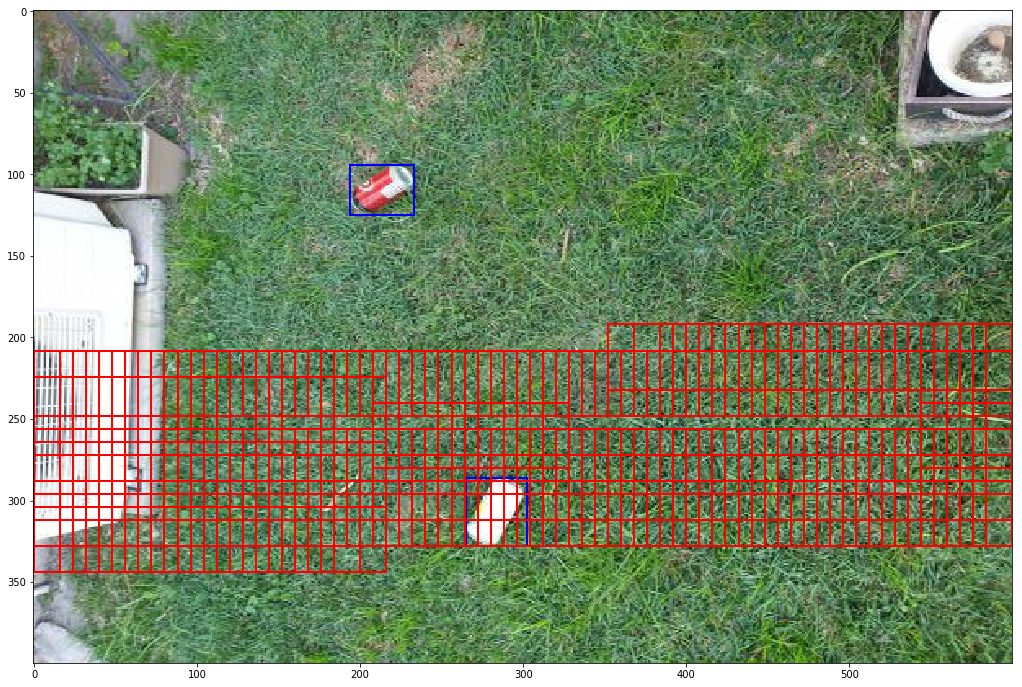

In [26]:
# 5: Draw the predicted boxes onto the image

# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['Plastic Bottle']

plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

for box in y_true[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='red', fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})